In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from helpers_plot import initPlot
initPlot()

In [2]:
alphas=[0.5, 1, 2]#, 1, 2]
folders={}
for alpha in alphas:
    folders[str(alpha)]=f"/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/LognormalFields_alpha_{alpha:.1f}/"

N = 4
Nlos=4096
ixs = []
for i in range(N):
    for j in range(i, N):
        for k in range(j, N):
            ix = i*N**2+j*N+k
            ixs.append(ix)
print(ixs)

[0, 1, 2, 3, 5, 6, 7, 10, 11, 15, 21, 22, 23, 26, 27, 31, 42, 43, 47, 63]


In [6]:
map3s={}
for alpha in alphas:
    map3=np.load(folders[str(alpha)]+"map_cubed_from_gamma_npix_4096_fieldsize_10.npy")
    map3 = map3.reshape(N*N*N, Nlos)
    map3s[str(alpha)] = map3[ixs]

In [7]:
# Load slics cov
map3_slics=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS/map_cubed").T
cov_SLICS=np.cov(map3_slics)
corr_SLICS=np.corrcoef(map3_slics)

cov_T1=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS/cov_infinite_term1Numerical_sigma_0.37_n_107987.71_thetaMax_7.87_gpu.dat")
cov_T2=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS/cov_square_term2Numerical_sigma_0.37_n_107987.71_thetaMax_7.87_gpu.dat")

map3_MS=np.loadtxt("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/MS/map_cubed").T
cov_MS=np.cov(map3_MS)
corr_MS=np.corrcoef(map3_MS)

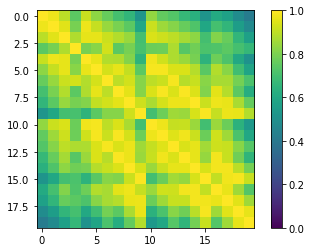

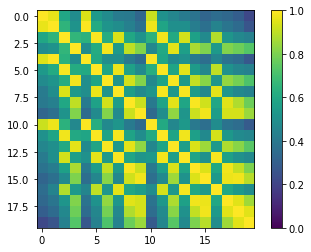

In [8]:
plt.imshow(corr_SLICS, vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(corr_MS, vmin=0, vmax=1)
plt.colorbar()
plt.show()

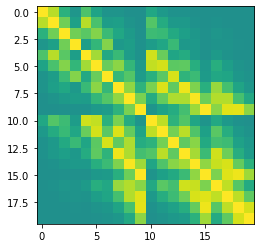

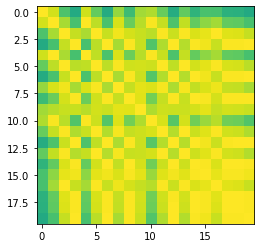

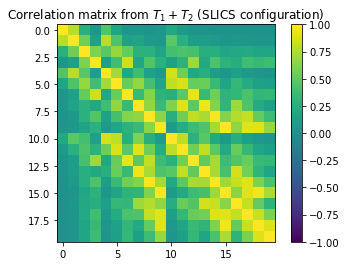

In [9]:
diag_T1=np.sqrt(np.diag(cov_T1))*np.eye(len(cov_T1))
diag_T1_inv=np.linalg.inv(diag_T1)
corr_T1=np.dot(diag_T1_inv,cov_T1).dot(diag_T1_inv)

diag_T2=np.sqrt(np.diag(cov_T2))*np.eye(len(cov_T2))
diag_T2_inv=np.linalg.inv(diag_T2)
corr_T2=np.dot(diag_T2_inv,cov_T2).dot(diag_T2_inv)


diag_T12=np.sqrt(np.diag(cov_T1+cov_T2))*np.eye(len(cov_T1))
diag_T12_inv=np.linalg.inv(diag_T12)
corr_T12=np.dot(diag_T12_inv,cov_T1+cov_T2).dot(diag_T12_inv)

plt.imshow(corr_T1, vmin=-1, vmax=1)
plt.show()
plt.imshow(corr_T2, vmin=-1, vmax=1)
plt.show()
plt.title(r"Correlation matrix from $T_1+T_2$ (SLICS configuration)")
plt.imshow(corr_T12, vmin=-1, vmax=1)
plt.colorbar()
plt.show()


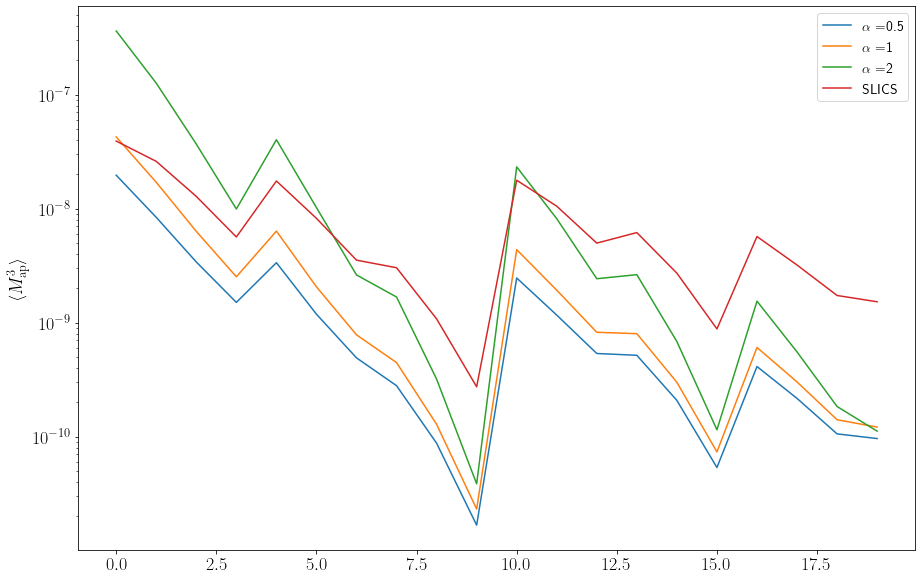

In [47]:
# Plot Map3 of log fields and SLICS
plt.figure(figsize=(15,10))
plt.yscale('log')
plt.ylabel(r"$\langle M_\mathrm{ap}^3\rangle$")
for alpha in alphas:
    mean=np.mean(map3s[str(alpha)], axis=1)
    plt.plot(mean, label=r"$\alpha=$"+str(alpha))

plt.plot(np.mean(map3_slics, axis=1), label='SLICS')
plt.legend()

In [12]:
# Load slics-like GRF
map3_grf=np.load("/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/GaussianRandomFields_slicslike/map_cubed_from_gamma_npix_4096_fieldsize_10.npy")
map3_grf = map3_grf.reshape(N*N*N, 4096)
map3_grf = map3_grf[ixs]
cov_grf=np.cov(map3_grf)

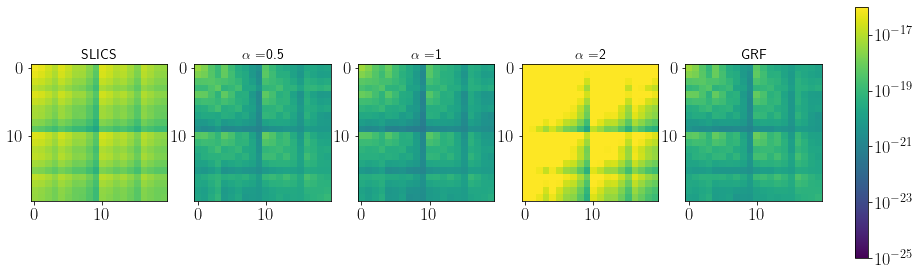

In [40]:
cov_alphas={}
fig, ax=plt.subplots(ncols=len(alphas)+2, figsize=(15,20))
#plt.suptitle("Aperture Statistics Covariances")
ax[0].set_title("SLICS")
ax[0].imshow(cov_SLICS, norm=LogNorm(vmin=1e-25, vmax=1e-16))
for i,alpha in enumerate(alphas):
    cov=np.cov(map3s[str(alpha)])
    cov_alphas[str(alpha)]=cov
    ax[i+1].set_title(r"$\alpha=$"+str(alpha))
    im=ax[i+1].imshow(cov, norm=LogNorm(vmin=1e-25, vmax=1e-16))
ax[-1].set_title("GRF")
ax[-1].imshow(cov_grf, norm=LogNorm(vmin=1e-25, vmax=1e-16))

fig.colorbar(im, ax=ax.ravel().tolist(),fraction=0.015, pad=0.04)



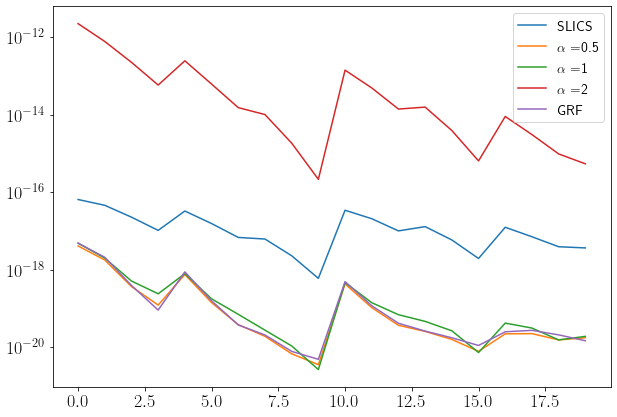

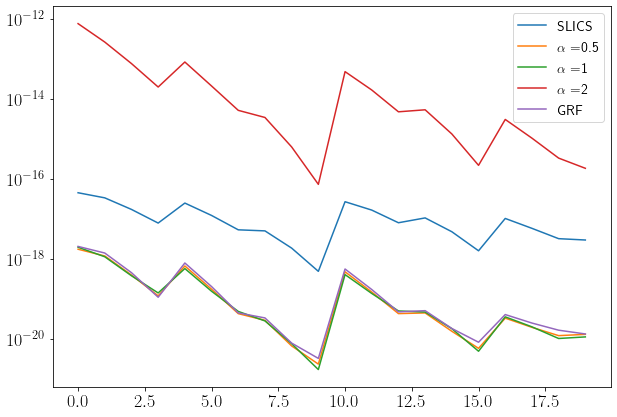

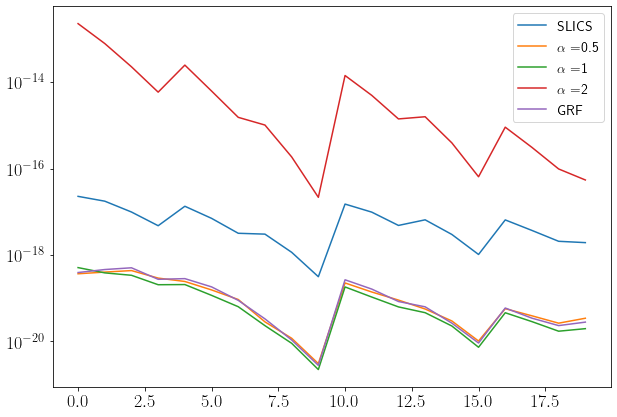

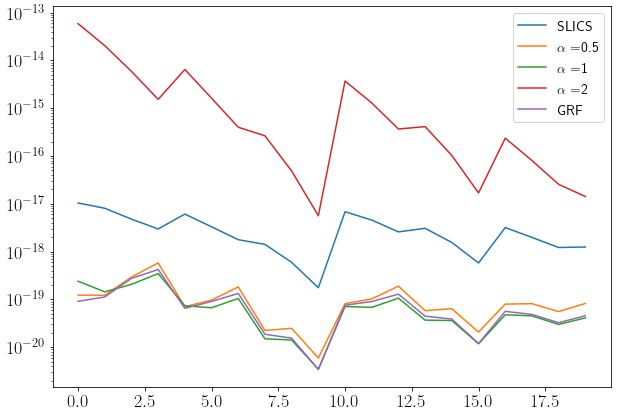

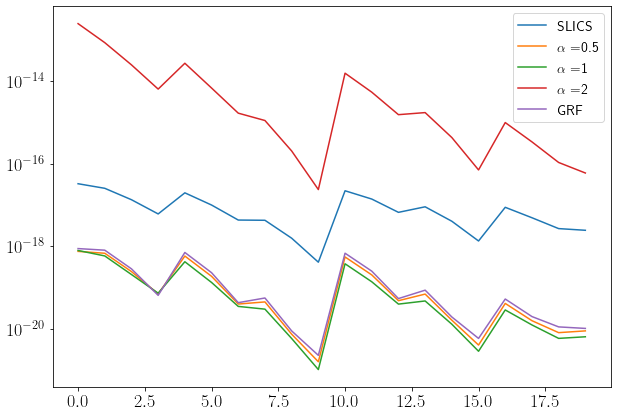

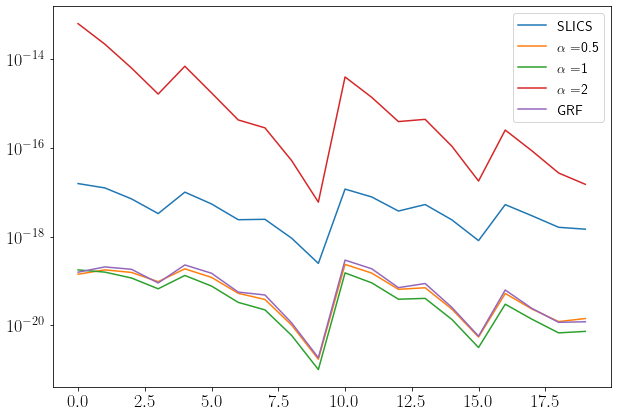

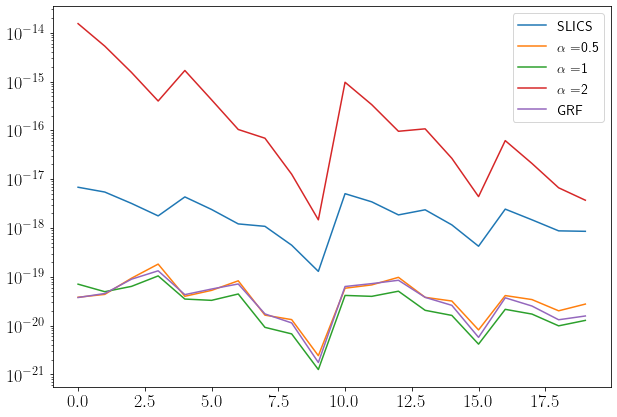

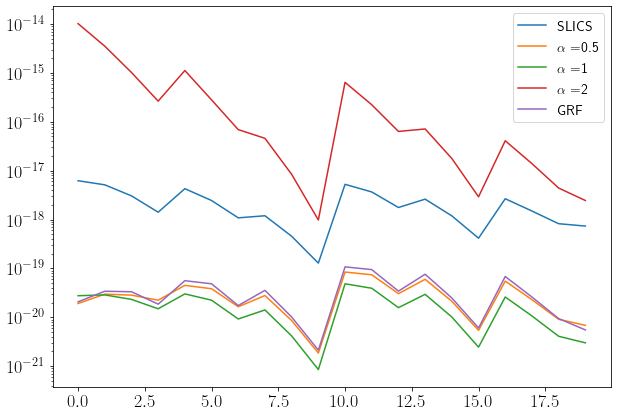

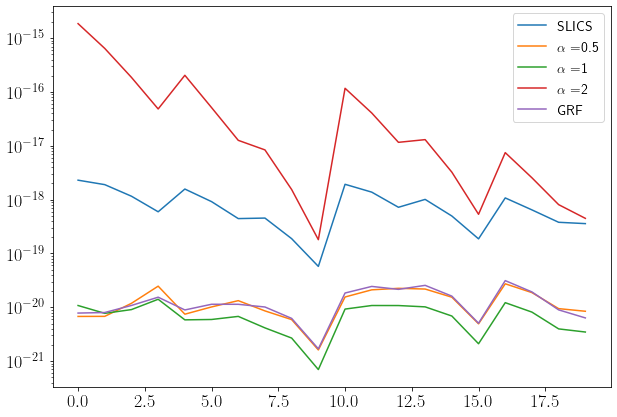

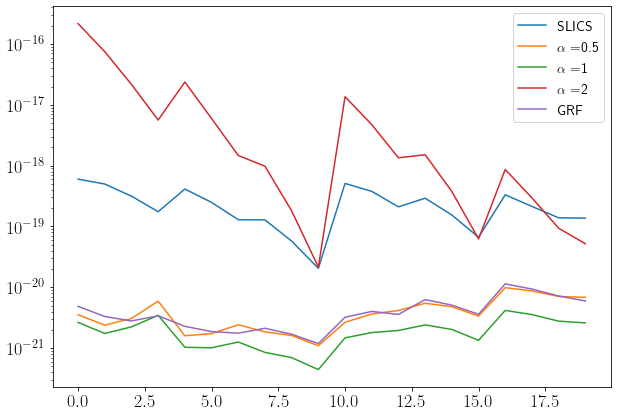

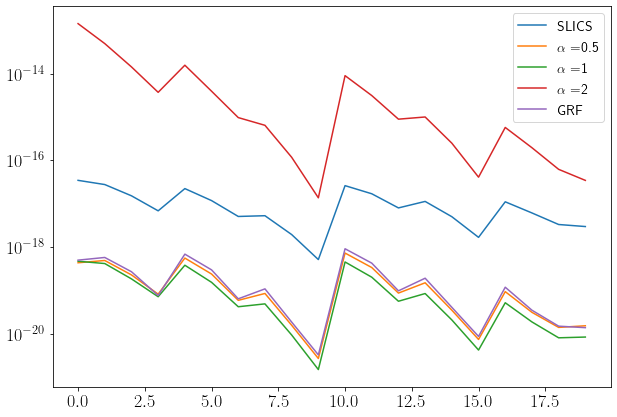

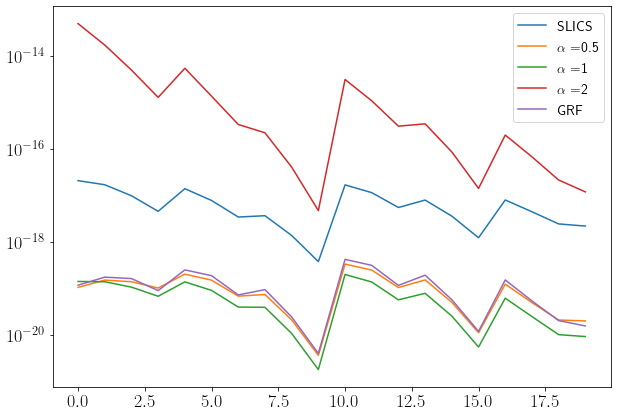

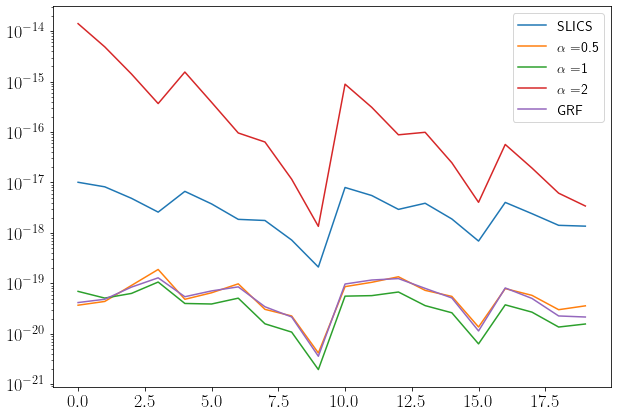

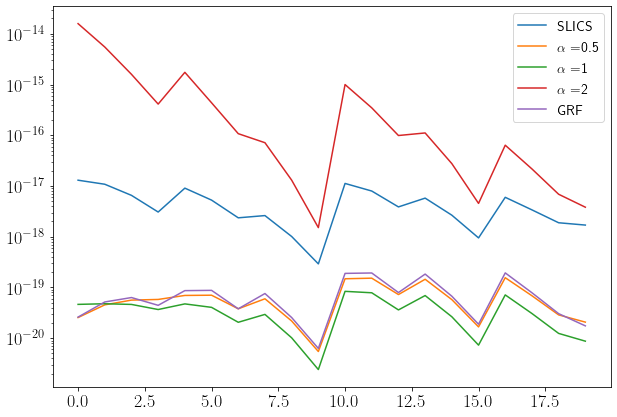

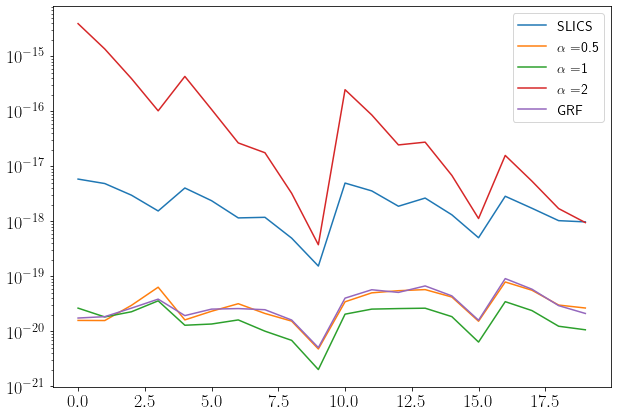

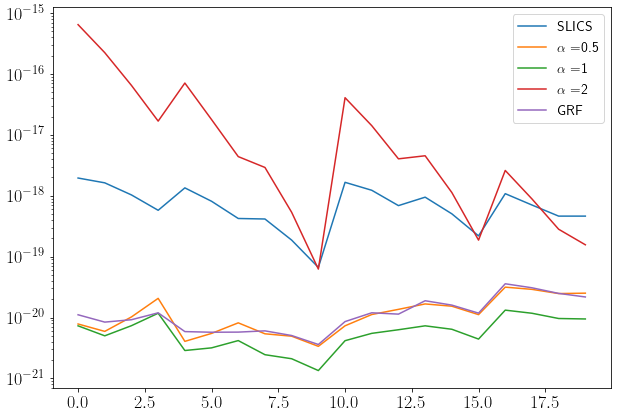

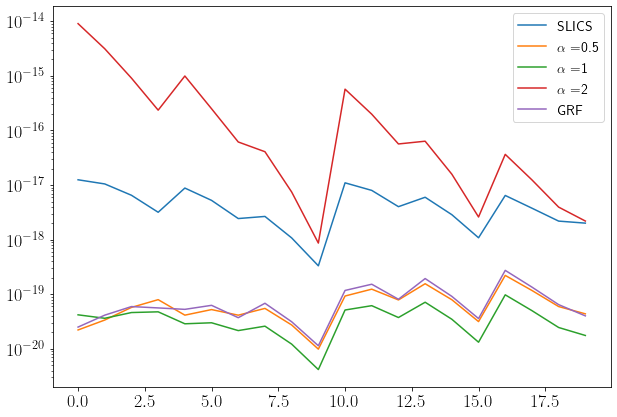

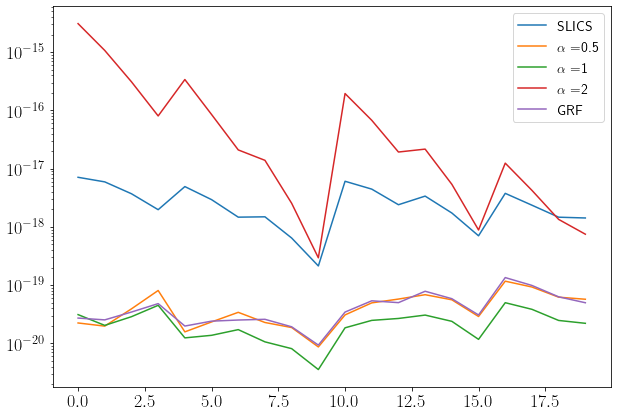

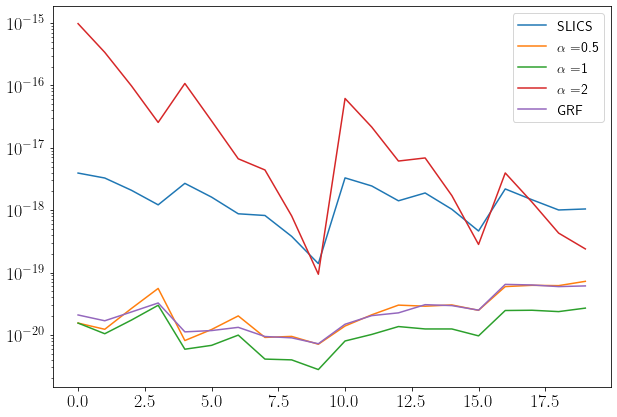

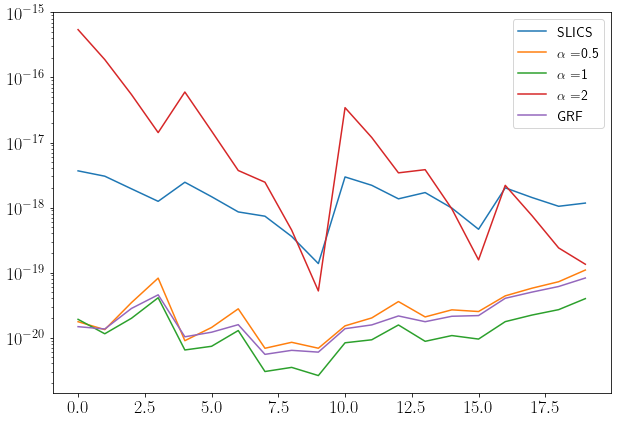

In [41]:
for i, line in enumerate(cov_SLICS):
    plt.figure(figsize=(10,7))
    plt.yscale('log')
    plt.plot(line, label='SLICS')
    for alpha in alphas:
        plt.plot(cov_alphas[str(alpha)][i], label=r"$\alpha=$"+str(alpha))
    plt.plot(cov_grf[i], label='GRF')
    plt.legend()
    plt.show()

In [21]:
def lognormal(x, alpha, sigma):
    A=sigma/np.sqrt(np.exp(alpha*alpha)-1)
    p=np.log(x/A+1)+0.5*alpha*alpha
    p=p*p
    p=p/2/alpha/alpha
    p=np.exp(-p)/np.sqrt(2*np.pi)/alpha/(x+A)
    return p

In [22]:
def gauss(x, sigma):
    p=-x*x/2/sigma/sigma
    p=np.exp(p)/np.sqrt(2*np.pi)/sigma
    return p

In [43]:
# Plot pdf of SLICS (single LOS)
from astropy.io import fits
filename="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/SLICS_DATA/convergence/kappa_noise_GalCatalog_LOS_cone1008.fits_s3331008_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits"
slics_kappa = fits.open(filename)[0].data[0]

<ipython-input-21-463423ab2c99>:3: RuntimeWarning: invalid value encountered in log
  p=np.log(x/A+1)+0.5*alpha*alpha
<ipython-input-21-463423ab2c99>:3: RuntimeWarning: invalid value encountered in log
  p=np.log(x/A+1)+0.5*alpha*alpha
<ipython-input-21-463423ab2c99>:3: RuntimeWarning: invalid value encountered in log
  p=np.log(x/A+1)+0.5*alpha*alpha


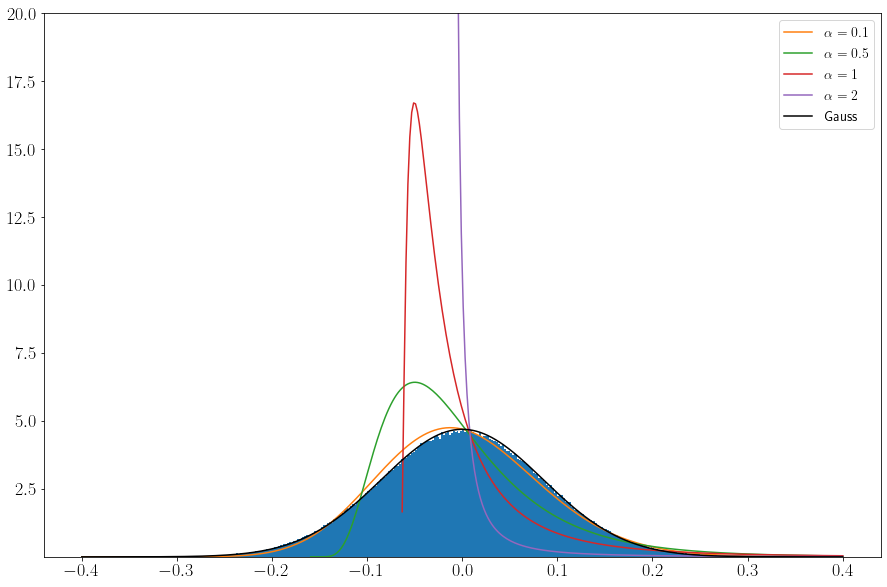

In [66]:
plt.figure(figsize=(15,10))
plt.hist(slics_kappa.ravel(), bins=400, range=(-0.4, 0.4), density=True)
x=np.linspace(-0.4, 0.4, num=400)


sigma=0.085

plt.ylim(1e-8, 20)
#plt.yscale('log')
plt.plot(x,lognormal(x, alpha=0.1, sigma=sigma), label=r"$\alpha=0.1$")
plt.plot(x,lognormal(x, alpha=0.5, sigma=sigma), label=r"$\alpha=0.5$")
plt.plot(x,lognormal(x, alpha=1, sigma=sigma), label=r"$\alpha=1$")
plt.plot(x,lognormal(x, alpha=2, sigma=sigma), label=r"$\alpha=2$")
plt.plot(x,gauss(x, sigma=sigma), label=r"Gauss", color='k')


plt.legend()